In [1]:
import os 
os.listdir('/kaggle/input') 

embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")


['speeches_with_embeddings.csv', 'speeches_embeddings_sentiment.csv', 'news_embeddings_sentiment.csv', 'all_texts_embeddings.joblib', 'news_with_embeddings.csv']


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

# Convert and verify date columns
news_embeddings['news_date'] = pd.to_datetime(news_embeddings['Date'])
speeches_embeddings['speech_date'] = pd.to_datetime(speeches_embeddings['date'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#Temporal window calculation and expansion
def generate_temporal_pairs(news_df, speeches_df, window_days=3):
    """Generate news-speech pairs within a symmetric temporal window (-3 to +3 days)"""
    pairs = []
    chunk_size = 2000
    news_chunks = np.array_split(news_df, len(news_df) // chunk_size + 1)
    
    for chunk in news_chunks:
        for _, row in chunk.iterrows():
            news_date = row['news_date']
            start_date = news_date - pd.Timedelta(days=window_days) 
            end_date = news_date + pd.Timedelta(days=window_days)  
            
            mask = (speeches_df['speech_date'] >= start_date) & (speeches_df['speech_date'] <= end_date)
            speech_ids = speeches_df[mask].index.tolist()
            pairs.extend([(row.name, s_id) for s_id in speech_ids])
    
    return pd.DataFrame(pairs, columns=['news_id', 'speech_id'])


alignment_df = generate_temporal_pairs(news_embeddings, speeches_embeddings)

#optimized embeddings calculation
def load_embeddings_half(df, col_name):
    embeddings = []
    for i, row in df.iterrows():
        if isinstance(row[col_name], str):
            arr = np.fromstring(row[col_name].strip("[]"), sep=" ", dtype=np.float16)
        else:
            arr = np.array(row[col_name], dtype=np.float16)
        embeddings.append(torch.tensor(arr, device=device).half())
        if i % 1000 == 0: torch.cuda.empty_cache()
    return torch.stack(embeddings)

news_tensor = load_embeddings_half(news_embeddings, 'news_embeddings')
speeches_tensor = load_embeddings_half(speeches_embeddings, 'speech_embeddings')

#Batched cosine similarity computation
def compute_cosine_similarities(pairs_df, news_emb, speech_emb, batch_size=8192):
    news_norm = F.normalize(news_emb, p=2, dim=1)
    speech_norm = F.normalize(speech_emb, p=2, dim=1)
    similarities = []
    for i in range(0, len(pairs_df), batch_size):
        batch = pairs_df.iloc[i:i+batch_size]
        news_batch = news_norm[batch['news_id'].values]
        speech_batch = speech_norm[batch['speech_id'].values]
        similarities.append(F.cosine_similarity(news_batch, speech_batch).cpu().numpy())
        del news_batch, speech_batch
        torch.cuda.empty_cache()
    return np.concatenate(similarities)

alignment_df['cosine_similarity'] = compute_cosine_similarities(alignment_df, news_tensor, speeches_tensor)

#include metadata to the embeddings to track temporal dependencies
def add_temporal_features(pairs_df, news_df, speeches_df):
    pairs_df = pairs_df.merge(
        news_df[['news_date']],
        left_on='news_id',
        right_index=True
    ).merge(
        speeches_df[['speech_date']],
        left_on='speech_id',
        right_index=True
    )
    pairs_df['days_diff'] = (pairs_df['news_date'] - pairs_df['speech_date']).dt.days
    return pairs_df

enriched_df = add_temporal_features(alignment_df, news_embeddings, speeches_embeddings)

#Save data to avoid rerunning everything again 
enriched_df.to_parquet('news_speech_similarities.parquet', engine='pyarrow', compression='zstd')
print("Processing complete. Results saved with columns:", enriched_df.columns.tolist())

Using device: cpu


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Processing complete. Results saved with columns: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff']


/tmp/ipykernel_101/322553216.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()


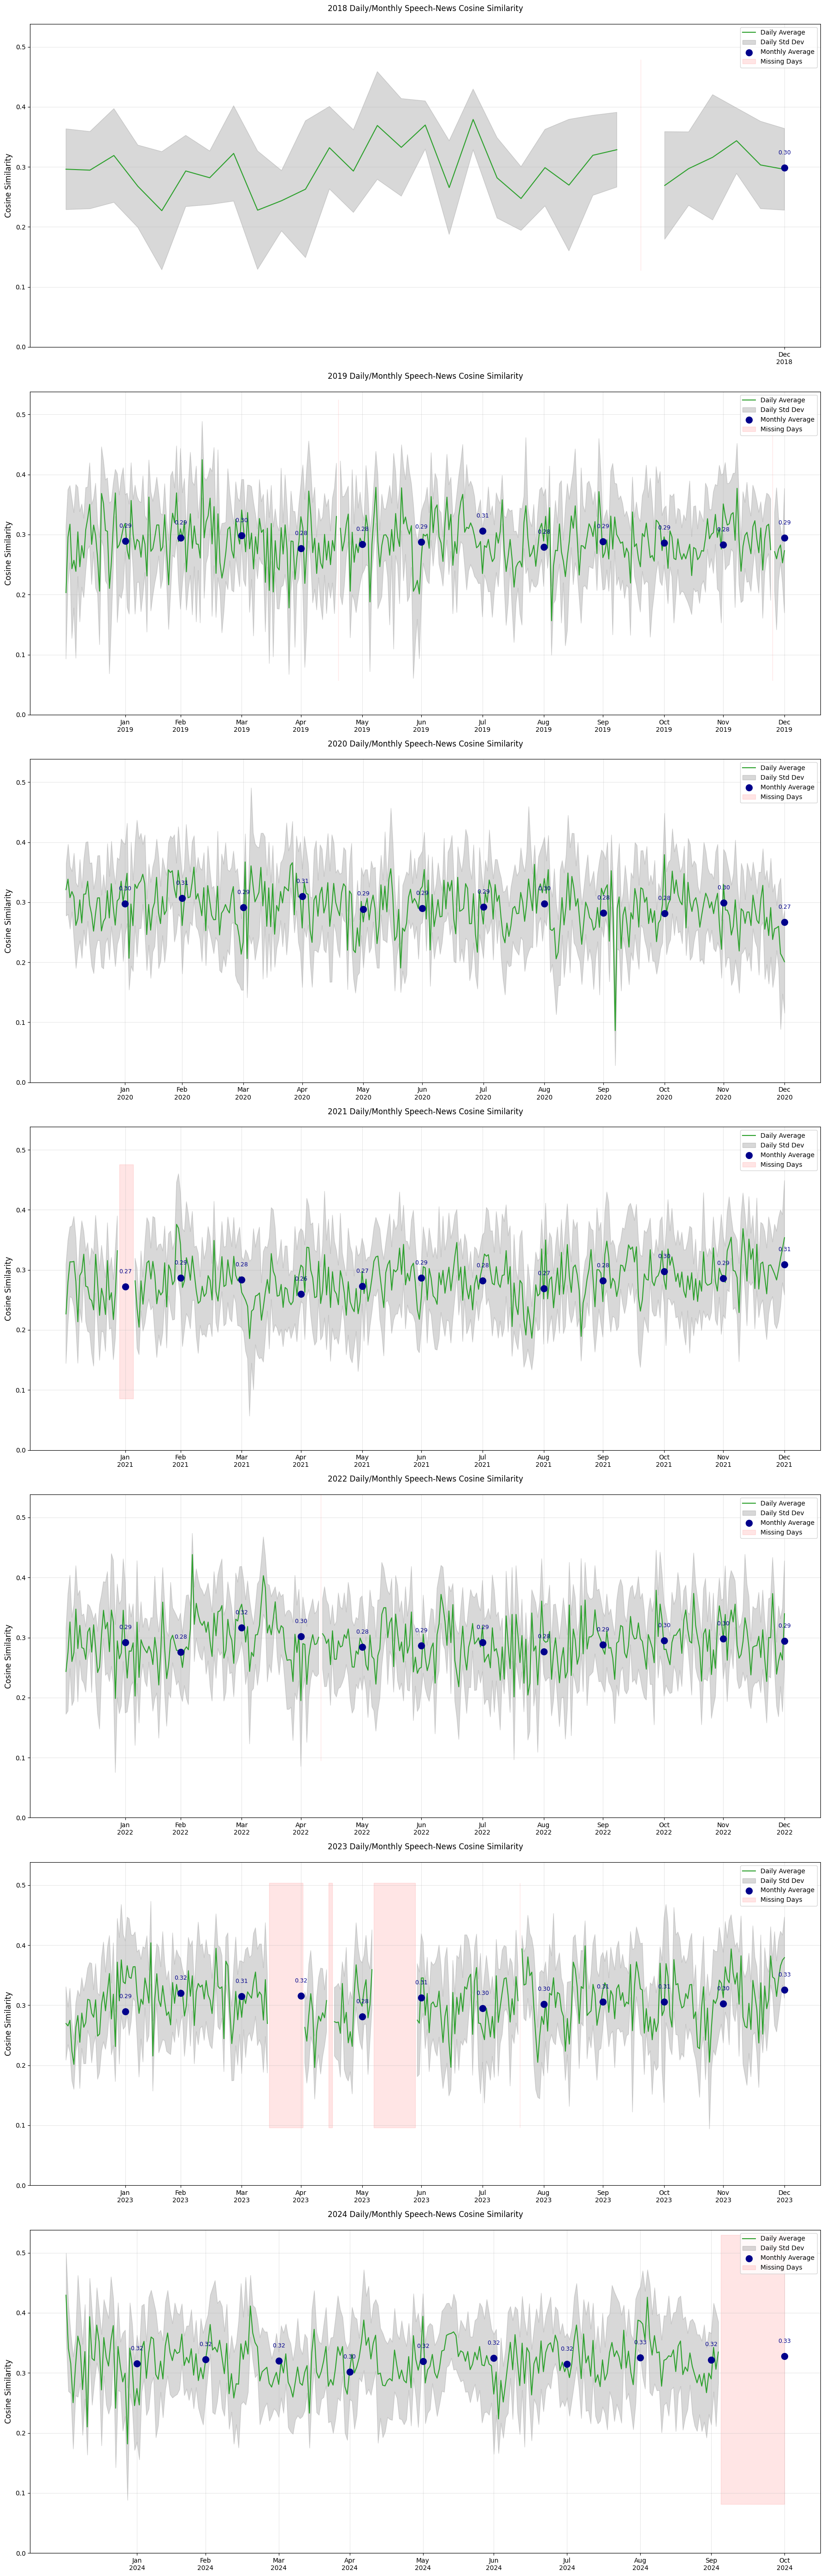

In [3]:
import matplotlib.pyplot as plt
# Load processed data
df = pd.read_parquet('news_speech_similarities.parquet') #We can use this code when we compute everything again, else we have to roead the parquet
#df = pd.read_parquet(SIMILARITIES_PATH) #Piece of code when we have the path defined, otherwise it'll work by loading them again. 
# Convert to datetime and normalize (remove time components)
df['news_date'] = pd.to_datetime(df['news_date']).dt.normalize()
df['year'] = df['news_date'].dt.year

# Create daily aggregates with std dev
daily_agg = df.groupby('news_date')['cosine_similarity'].agg(['mean', 'std']).reset_index()
daily_agg.columns = ['date', 'cosine_similarity', 'std_dev']

# Extend full_dates to include October 2024 explicitly
end_date = pd.to_datetime('2024-10-31')  # Adjust as needed
full_dates = pd.date_range(
    start=daily_agg['date'].min(), 
    end=end_date, 
    freq='D'
)
daily_agg = daily_agg.set_index('date').reindex(full_dates).reset_index().rename(columns={'index': 'date'})

# Calculate bounds
daily_agg['upper_bound'] = daily_agg['cosine_similarity'] + daily_agg['std_dev'].fillna(0)
daily_agg['lower_bound'] = daily_agg['cosine_similarity'] - daily_agg['std_dev'].fillna(0)

# Create monthly aggregates (fill NaN with 0 for plotting)
monthly_agg = daily_agg.set_index('date').resample('M')['cosine_similarity'].mean().fillna(0).reset_index()
monthly_agg['month_label'] = monthly_agg['date'].dt.strftime('%b\n%Y')

# Get unique years present in data
years = daily_agg['date'].dt.year.unique()

# Set up plot
plt.figure(figsize=(18, 8 * len(years)))

for i, year in enumerate(years, 1):
    year_mask = daily_agg['date'].dt.year == year
    yearly_daily = daily_agg[year_mask]
    yearly_monthly = monthly_agg[monthly_agg['date'].dt.year == year]
    
    if yearly_daily.empty:
        continue
    
    ax = plt.subplot(len(years), 1, i)
    
    # Daily plot with variability
    ax.plot(yearly_daily['date'], 
            yearly_daily['cosine_similarity'], 
            color='#2ca02c', 
            linewidth=1.5,
            label='Daily Average')
    
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['upper_bound'],
                    yearly_daily['lower_bound'],
                    color='gray', alpha=0.3, 
                    label='Daily Std Dev')
    
    # Monthly markers (plot even if value is 0)
    ax.scatter(yearly_monthly['date'], 
               yearly_monthly['cosine_similarity'],
               color='darkblue', 
               s=100,
               zorder=5,
               label='Monthly Average')
    
    # Annotate monthly values (skip if 0)
    for _, row in yearly_monthly.iterrows():
        if row['cosine_similarity'] != 0:
            ax.text(row['date'], row['cosine_similarity']+0.02,
                    f"{row['cosine_similarity']:.2f}",
                    ha='center', va='bottom',
                    fontsize=9, color='darkblue')
    
    # Highlight missing days
    missing_mask = yearly_daily['cosine_similarity'].isna()
    ax.fill_between(yearly_daily['date'],
                    yearly_daily['cosine_similarity'].min() - 0.1,
                    yearly_daily['cosine_similarity'].max() + 0.1,
                    where=missing_mask,
                    color='red', alpha=0.1,
                    label='Missing Days')
    
    # Formatting
    ax.set_title(f'{year} Daily/Monthly Speech-News Cosine Similarity', pad=20)
    ax.set_xlabel('')
    ax.set_ylabel('Cosine Similarity', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    # Set monthly x-ticks
    ax.set_xticks(yearly_monthly['date'])
    ax.set_xticklabels(yearly_monthly['month_label'])
    
    # Set y-axis limits
    y_min = max(daily_agg['cosine_similarity'].min() - 0.1, 0)
    y_max = min(daily_agg['cosine_similarity'].max() + 0.1, 1)
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [4]:
import re
# again extracting top media outlets. Maybe there is a more efficient way to do this. 
def extract_outlet(url):
    patterns = [r"https?://(?:www\.)?([^/.]+)\."]
    match = re.search(patterns[0], str(url), re.IGNORECASE)
    return match.group(1).lower() if match else "unknown"

# Create outlet column in news_embeddings
news_embeddings['outlet'] = news_embeddings['Link'].apply(extract_outlet)

In [5]:
# Now this will work

enriched_df = enriched_df.merge(
    news_embeddings[['outlet']],
    left_on='news_id',
    right_index=True,
    how='left'
)

# Final check
print("\nColumns in enriched_df:", enriched_df.columns.tolist())
print("Sample outlets:", enriched_df['outlet'].unique()[:5])


Columns in enriched_df: ['news_id', 'speech_id', 'cosine_similarity', 'news_date', 'speech_date', 'days_diff', 'outlet']
Sample outlets: ['bbc' 'politica' 'oem' 'eleconomista' 'milenio']


### First regressions

In regression 1, I have to change the variable days_diff into dummies. 
In regression 2, I have to  

In [6]:
import pandas as pd
import statsmodels.api as sm

# 1. Create dummy variables for outlets
dummies_outlet = pd.get_dummies(enriched_df['outlet'], prefix='outlet')

# 2. Filter for top outlets
top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()
dummy_outlet_columns = [f'outlet_{outlet}' for outlet in top_outlets if f'outlet_{outlet}' in dummies_outlet.columns]
dummies_outlet = dummies_outlet[dummy_outlet_columns]

# 3. Create dummies for days_diff
enriched_df['days_diff'] = pd.to_numeric(enriched_df['days_diff'], errors='coerce')
dummies_days = pd.get_dummies(enriched_df['days_diff'], prefix='days_diff')
dummies_days = dummies_days.drop(columns='days_diff_0', errors='ignore')  # Drop baseline

# 4. Combine dummies
dummies = pd.concat([dummies_outlet, dummies_days], axis=1)

# 5. Handle missing values
valid_data = enriched_df[['cosine_similarity']].join(dummies).dropna()

# ✅ Ensure all columns are numeric
X = sm.add_constant(valid_data[dummies.columns]).astype(float)
y = valid_data['cosine_similarity'].astype(float)

# 6. Run regression
model = sm.OLS(y, X).fit(cov_type='HC3')

# 7. Output summary
print("\n=== Outlet + Days Diff Fixed Effects Model ===")
print(model.summary())



=== Outlet + Days Diff Fixed Effects Model ===
                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                 1.500e+05
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:36:01   Log-Likelihood:             2.7810e+07
No. Observations:            24418171   AIC:                        -5.562e+07
Df Residuals:                24418154   BIC:                        -5.562e+07
Df Model:                          16                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

## Regression with temporal dependencies (dummies per month and year)¶

In [7]:
import gc
gc.collect()

384

In [6]:
print("Unique days_diff values:", enriched_df['days_diff'].unique())
print(enriched_df.shape) 
print(enriched_df.head(2))

Unique days_diff values: [-3 -2 -1  0  1  2  3]
(24418171, 7)
   news_id  speech_id  cosine_similarity  news_date speech_date  days_diff  \
0        0     150494            0.31543 2018-12-01  2018-12-04         -3   
1        0     150495            0.31543 2018-12-01  2018-12-04         -3   

  outlet  
0    bbc  
1    bbc  


In [10]:
top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()

# Add 'Other' only if not already a category
if 'Other' not in enriched_df['outlet'].cat.categories:
    enriched_df['outlet'] = enriched_df['outlet'].cat.add_categories('Other')

# Reassign rare outlets to 'Other'
enriched_df.loc[~enriched_df['outlet'].isin(top_outlets), 'outlet'] = 'Other'

# Ensure categories are unique before setting
all_categories = pd.Index(top_outlets + ['Other']).unique()
enriched_df['outlet'] = enriched_df['outlet'].cat.set_categories(all_categories)


In [7]:
import pandas as pd
import statsmodels.formula.api as smf

# --- Data Preparation ---
# Convert to categorical types upfront
enriched_df = enriched_df.astype({
    'outlet': 'category',
    'news_date': 'datetime64[ns]',
    'speech_date': 'datetime64[ns]'
})

# Create temporal features without expanding memory
enriched_df['month'] = enriched_df['news_date'].dt.month.astype('int8')
enriched_df['year'] = enriched_df['news_date'].dt.year.astype('int16')

# Filter to top outlets based on frequency
top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()

# --- Minimal changes to recode outlet ---
# First, add 'Other' as a valid category, then recode.
enriched_df['outlet'] = enriched_df['outlet'].cat.add_categories('Other')
enriched_df.loc[~enriched_df['outlet'].isin(top_outlets), 'outlet'] = 'Other'
enriched_df['outlet'] = enriched_df['outlet'].cat.set_categories(top_outlets + ['Other'])

# Downcast numerical columns for efficiency
enriched_df['cosine_similarity'] = pd.to_numeric(enriched_df['cosine_similarity'], downcast='float')
enriched_df['days_diff'] = pd.to_numeric(enriched_df['days_diff'], downcast='integer')

# If days_diff should only be between -3 and +3, filter the data:
enriched_df = enriched_df[enriched_df['days_diff'].between(-3, 3)]

# --- Instead of using the full dataset, take a subsample for estimation ---
# Adjust the sample size as needed (here, 100000 observations are used)
sample_size = 10000000
enriched_sample = enriched_df.sample(n=sample_size, random_state=42)

# --- Model Specification ---
# Treat days_diff as categorical to generate dummy variables (7 dummies max) and 0 as reference in days_diff
formula = """cosine_similarity ~ C(days_diff, Treatment(reference=0)) + 
C(outlet, Treatment('Other')) + 
C(month) + 
C(year)
"""

# Fit model on the subsample with robust standard errors
model = smf.ols(formula, data=enriched_sample, missing='drop').fit(cov_type='HC3')

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                 4.634e+04
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:56:33   Log-Likelihood:             1.1627e+07
No. Observations:            10000000   AIC:                        -2.325e+07
Df Residuals:                 9999966   BIC:                        -2.325e+07
Df Model:                          33                                         
Covariance Type:                  HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [ ]:
#with 0 as reference

In [17]:
#Random effects model 
import statsmodels.formula.api as smf

# Define the model formula without C(outlet), since it's your random grouping variable
formula = "cosine_similarity ~ C(days_diff) + C(month) + C(year)"

# Fit the random effects model: random intercepts by outlet
md = smf.mixedlm(formula, data=enriched_sample, groups=enriched_sample["outlet"])
model_re = md.fit(method='lbfgs', maxiter=200)

# Output summary
print(model_re.summary())



/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


              Mixed Linear Model Regression Results
Model:            MixedLM   Dependent Variable: cosine_similarity
No. Observations: 10000000  Method:             REML             
No. Groups:       10        Scale:              0.0057           
Min. group size:  241919    Log-Likelihood:     11618560.5701    
Max. group size:  3568987   Converged:          Yes              
Mean group size:  1000000.0                                      
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              0.286    0.024  11.936 0.000  0.239  0.333
C(days_diff)[T.-2]    -0.001    0.000  -9.048 0.000 -0.001 -0.001
C(days_diff)[T.-1]    -0.001    0.000  -7.865 0.000 -0.001 -0.001
C(days_diff)[T.0]      0.005    0.000  51.627 0.000  0.004  0.005
C(days_diff)[T.1]     -0.002    0.000 -21.559 0.000 -0.002 -0.002
C(days_diff)[T.2]     -0

In [12]:
#mixed model
# Create 'top_outlet' column
import pandas as pd
import statsmodels.api as sm

# --- Data Preparation ---
enriched_df = enriched_df.astype({
    'outlet': 'category',
    'news_date': 'datetime64[ns]',
    'speech_date': 'datetime64[ns]'
})

# Extract temporal features
enriched_df['month'] = enriched_df['news_date'].dt.month.astype('int8')
enriched_df['year'] = enriched_df['news_date'].dt.year.astype('int16')

# Top outlets only
top_outlets = enriched_df['outlet'].value_counts().nlargest(10).index.tolist()

# Add 'Other' category if not present and recode
enriched_df['outlet'] = enriched_df['outlet'].cat.add_categories('Other')
enriched_df.loc[~enriched_df['outlet'].isin(top_outlets), 'outlet'] = 'Other'
enriched_df['outlet'] = enriched_df['outlet'].cat.set_categories(top_outlets + ['Other'])

# New variable for fixed-effects top outlets
enriched_df['top_outlet'] = enriched_df['outlet']

# Downcast for efficiency
enriched_df['cosine_similarity'] = pd.to_numeric(enriched_df['cosine_similarity'], downcast='float')
enriched_df['days_diff'] = pd.to_numeric(enriched_df['days_diff'], downcast='integer')

# Filter days_diff
enriched_df = enriched_df[enriched_df['days_diff'].between(-3, 3)]

# --- Sampling for estimation ---
sample_size = 1_000_000  # adjust if you want larger
enriched_sample = enriched_df.sample(n=sample_size, random_state=42)



In [13]:
# --- Mixed Effects Model ---
# Use 'top_outlet' for fixed effects, and 'outlet' for random intercepts
md = sm.MixedLM.from_formula(
    "cosine_similarity ~ C(days_diff) + C(top_outlet, Treatment('Other')) + C(month) + C(year)",
    groups="outlet",  # random intercepts for outlet
    data=enriched_sample
)
model_re = md.fit(reml=False)
print(model_re.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

                            Mixed Linear Model Regression Results
Model:                      MixedLM           Dependent Variable:           cosine_similarity
No. Observations:           1000000           Method:                       ML               
No. Groups:                 11                Scale:                        0.0057           
Min. group size:            17940             Log-Likelihood:               1163788.3424     
Max. group size:            338928            Converged:                    No               
Mean group size:            90909.1                                                          
---------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                          0.271    0.002 167.971 0.000  0.268  

In [7]:
print(enriched_df.head(2))

   news_id  speech_id  cosine_similarity  news_date speech_date  days_diff  \
0        0     150494            0.31543 2018-12-01  2018-12-04         -3   
1        0     150495            0.31543 2018-12-01  2018-12-04         -3   

  outlet  lag_cosine  
0    bbc         NaN  
1    bbc     0.31543  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()


In [15]:
import pandas as pd
import statsmodels.formula.api as smf

# --- Sort and Create Lagged Variable ---
enriched_df.sort_values(['news_date', 'days_diff'], inplace=True)

# Create lagged cosine similarity within each event (news_date)
enriched_df['lag_cosine'] = enriched_df.groupby('news_date')['cosine_similarity'].shift(1)

# Drop rows with no lag value (first in each group)
df_dynamic = enriched_df.dropna(subset=['lag_cosine'])

# Optional: sample if the dataset is large
sample_size = 10_000_000  # Adjust if needed
df_dynamic_sample = df_dynamic.sample(n=sample_size, random_state=42)

# --- Define and run the dynamic model ---
formula = """
cosine_similarity ~ lag_cosine + C(days_diff, Treatment(reference=0)) + I(days_diff**2) +
C(outlet, Treatment('Other')) +
C(month) + 
C(year)
"""

model_dyn = smf.ols(formula, data=df_dynamic_sample, missing='drop').fit(cov_type='HC3')
print(model_dyn.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 35, but rank is 1
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:      cosine_similarity   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                    0.2607
Date:                Sat, 19 Apr 2025   Prob (F-statistic):              0.610
Time:                        13:10:12   Log-Likelihood:             3.2452e+07
No. Observations:            10000000   AIC:                        -6.490e+07
Df Residuals:                 9999964   BIC:                        -6.490e+07
Df Model:                          35                                         
Covariance Type:                  HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [8]:
##lagged cosine model 

# Sort by news_id (event) and days_diff (from -3 to +3)
enriched_df.sort_values(['news_date', 'days_diff'], inplace=True)

# Create a lagged cosine_similarity variable for each event
enriched_df['lag_cosine'] = enriched_df.groupby('news_date')['cosine_similarity'].shift(1)
# Drop the first observation of each event since it won’t have a lag value
df_dynamic = enriched_df.dropna(subset=['lag_cosine'])



In [ ]:
import statsmodels.formula.api as smf

# Define your dynamic model with a non-linear term for days_diff:
formula = """
cosine_similarity ~ lag_cosine + days_diff + I(days_diff**2) +
C(outlet, Treatment('Other')) +
C(month) + 
C(year)
"""

model_dyn = smf.ols(formula, data=df_dynamic, missing='drop').fit(cov_type='HC3')
print(model_dyn.summary())

### Analysis of errors 
